#  Reccomendations: IBM Watson Studio 
---

PROJECT DESCRIPTION

## Table of Contents

In [28]:
#Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
# Import data
user_item_df = pd.read_csv('data/user-item-interactions.csv').drop(columns=['Unnamed: 0'])
content_df = pd.read_csv('data/articles_community.csv').drop(columns=['Unnamed: 0'])

## 1. Exploratory Data Analysis

DATA ANALYSIS DESCRTIPTION

In [11]:
content_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [14]:
user_item_df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [20]:
# Remove nulls from the data 
user_item_df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [17]:
# Drop nulls as we cannot identify the relevent customer email
user_item_df.dropna(inplace = True) 

In [22]:
# Dont need to drop 
content_df.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

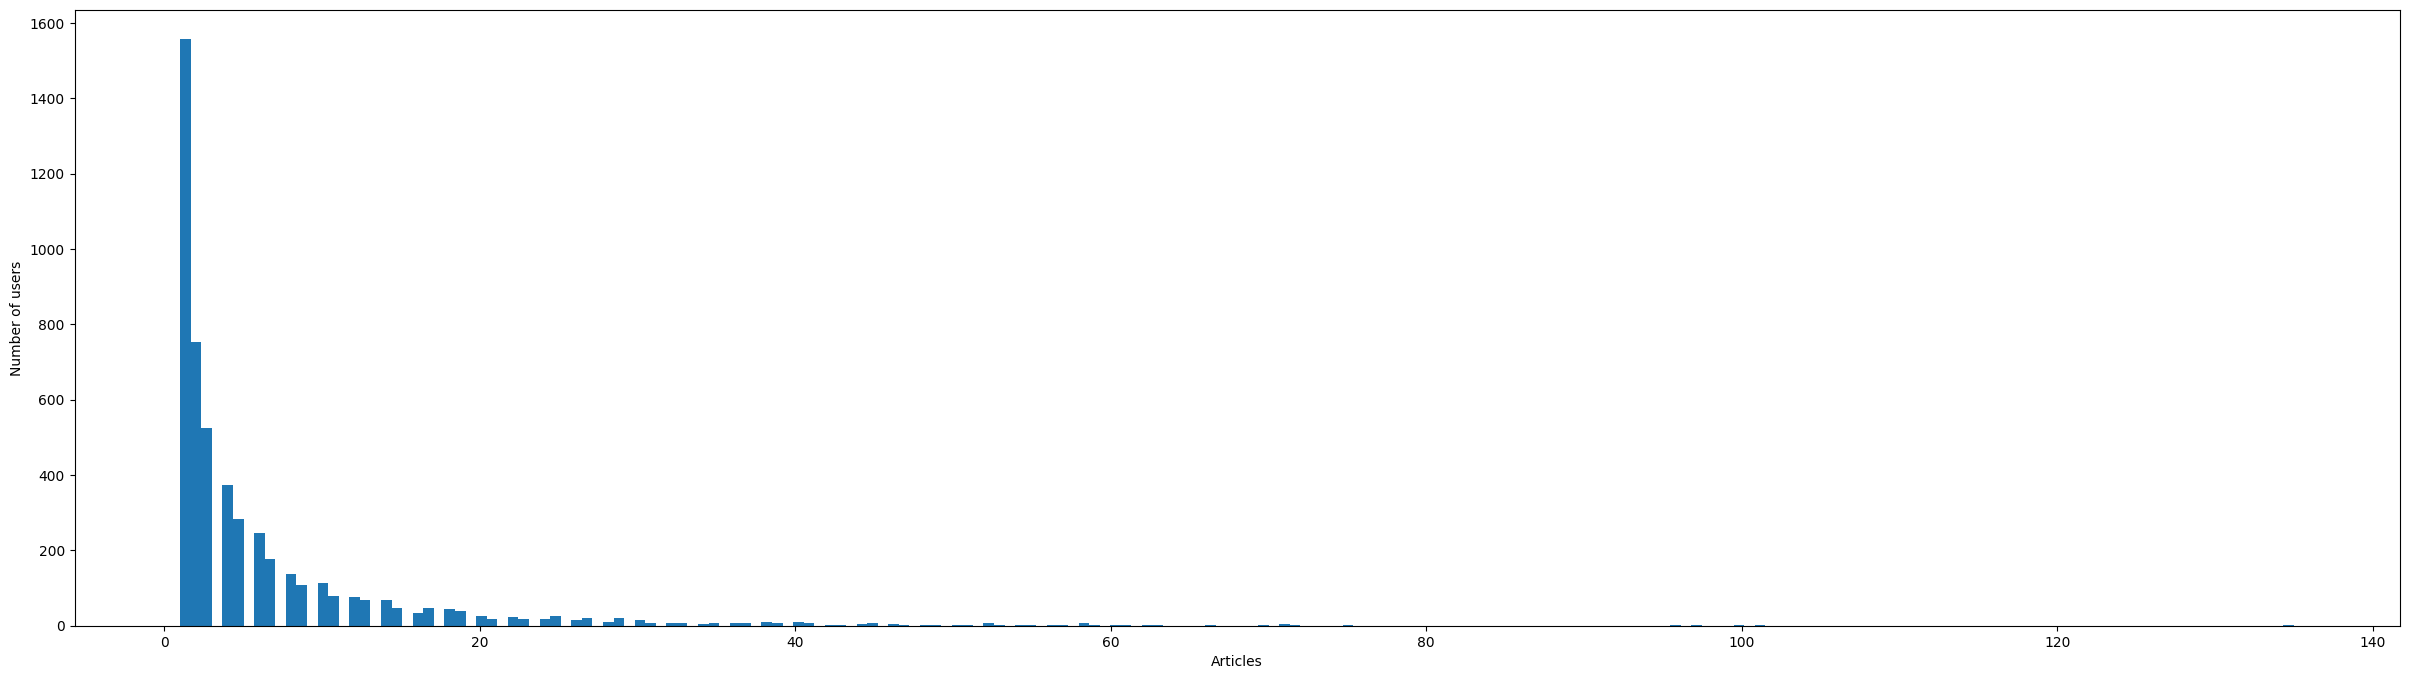

In [43]:
#Understand the distribution of articles read 
plt.figure(figsize=(30,8))
plt.hist(user_item_df.groupby('email').nunique()['article_id'], bins=200);
plt.xlabel('Articles')
plt.ylabel('Number of users')
plt.show()